In [1]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import community
import community.community_louvain as community_louvain
import networkx as nx
import random
import collections
import csv
import seaborn as sns

In [ ]:
def data_graph(dataset, delimiter):
    
    data = pd.read_csv(dataset, delimiter=delimiter)
    print(data.shape)
    if dataset == 'epinion.txt':
        data.columns = ['From','To','Weight']
    elif dataset == 'bitcoin.csv':
        data.columns = ['From','To','Weight','Time']
    print(data.head())
    
    graph = nx.DiGraph()
    # Adding the edges.
    for index,row in data.iterrows():
        graph.add_edges_from([(row[0],row[1])],weight = row[2])
  #  print(graph)
    
    return data, graph

In [ ]:
epi_csv, epi_graph = data_graph('epinion.txt',"\t")

(252842, 3)
   From        To  Weight
0     0       1.0    -1.0
1     1  128552.0    -1.0
2     2       3.0     1.0
3     4       5.0    -1.0
4     4     155.0    -1.0


In [ ]:
bitcoin_csv, bitcoin_graph = data_graph('bitcoin.csv',",")

(35592, 4)
   From  To  Weight          Time
0     6   2       4  1.289242e+09
1     6   5       2  1.289242e+09
2     1  15       1  1.289243e+09
3     4   3       7  1.289245e+09
4    13  16       8  1.289254e+09


In [ ]:
def recrprocity(data, skip):
    pos = data.loc[data['Weight'] > 0]
    neg = data.loc[data['Weight'] < 0]
    graphP = nx.DiGraph()
    # Adding the edges.

    for index,row in pos.iterrows():
        graphP.add_edges_from([(row[0],row[1])])
    print('+ve reciprocity: ' + str(nx.reciprocity(graphP)))

    if not skip:
        graphN = nx.DiGraph()
        # Adding the edges.
        for index,row in neg.iterrows():
            graphN.add_edges_from([(row[0],row[1])])
        print('-ve reciprocity: ' + str(nx.reciprocity(graphN)))

In [ ]:
recrprocity(epi_csv, False)

+ve reciprocity: 0.24025654458573448
-ve reciprocity: 0.02223335629736331


In [ ]:
recrprocity(bitcoin_csv, False)

+ve reciprocity: 0.8391145524368541
-ve reciprocity: 0.17064271681167556


In [ ]:
def stats(data,graph):
    # Number of nodes
    print('Nodes = ' + str(graph.number_of_nodes()))

    # Number of edges
    print('Edges = ' + str(graph.number_of_edges()))

    # Positive and negative edges 

    Stats = pd.DataFrame(graph.out_degree(),columns=['From','Outdegree']).sort_values('From')
    Stats_2 =  pd.DataFrame(graph.in_degree(),columns=['To','Indegree']).sort_values('To')

    b= data.groupby('From',as_index=False)[['Weight']].sum().sort_values('From')
    c= data.groupby('To',as_index=False)[['Weight']].sum().sort_values('To')

    Stats = Stats.merge(b,on='From',how='left')
    Stats_2 = Stats_2.merge(c,on='To',how='left')

    Stats['Pos_out'] = (  Stats['Outdegree'] + Stats['Weight']  )/2
    Stats['Neg_out'] = (  Stats['Outdegree'] - Stats['Weight']  )/2
    Stats_2['Pos_in']= (Stats_2['Indegree']  + Stats_2['Weight'])/2
    Stats_2['Neg_in']= (Stats_2['Indegree']  - Stats_2['Weight'])/2
    
    Stats = pd.merge(Stats,Stats_2,left_on='From', right_on='To').drop('To', axis=1)
    Stats = Stats.drop(['Weight_x','Weight_y'],axis=1)
    Stats.fillna(0,inplace=True)
    print(Stats.head())
    
    print(Stats.describe())
    print(Stats.max(axis=0))
    
    print('Average Clustering = ' + str(nx.average_clustering(graph)))
    print('Transitivity = '+ str(nx.transitivity(graph)))
    print('Density = ' + str(nx.density(graph)))
    
    data['Weight'].plot.hist(bins=2, alpha=1, align='mid', color='purple', edgecolor='black')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('weight of edges')
    plt.xticks([-1,1])
    plt.show()
    plt.savefig('line plot.jpg',bbox_inches='tight', dpi=150)
    
    return Stats

Nodes = 41658
Edges = 252842
   From  Outdegree  Pos_out  Neg_out  Indegree  Pos_in  Neg_in
0   0.0          1      0.0      1.0         0     0.0     0.0
1   1.0          1      0.0      1.0         1     0.0     1.0
2   2.0          1      1.0      0.0         1     1.0     0.0
3   3.0          0      0.0      0.0         4     4.0     0.0
4   4.0         14      9.0      5.0         1     1.0     0.0
                From     Outdegree       Pos_out       Neg_out      Indegree  \
count   41658.000000  41658.000000  41658.000000  41658.000000  41658.000000   
mean    48811.069278      6.069470      4.536308      1.533163      6.069470   
std     38532.971240     40.470029     30.355978     20.441754     20.965253   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%     13865.250000      0.000000      0.000000      0.000000      1.000000   
50%     40827.000000      0.000000      0.000000      0.000000      1.000000   
75%     79092.750000      0.00000

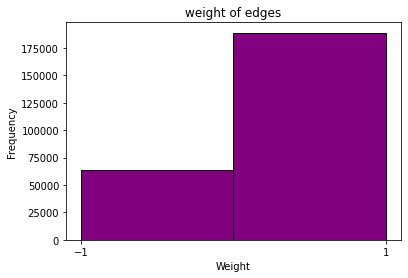

<Figure size 432x288 with 0 Axes>

In [ ]:
epi_Stats = stats(epi_csv,epi_graph)

In [ ]:
def degreeDistribution(data,graph):
    
    degree_sequence = sorted([d for n, d in graph.in_degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    #print(degreeCount)
    deg, cnt = zip(*degreeCount.items())
    #deg, cnt = np.array(deg), deg.array(cnt)
#     print(len(deg))
#     deg = deg[0:100]
#     cnt = cnt[0:100]
#     print(len(deg))
    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot(deg,cnt,color="#3F5D7D")
    plt.xlabel('In-Degree (Number of Connections)')
    plt.ylabel('Number of nodes')
    plt.title('Actual Plot(Epinion)')
    plt.grid()
    plt.xlim([0, 1000])
    plt.show()
    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.bar(deg,(np.log(cnt)),color = 'b')
    #plt.plot(n1)
    #plt.plot(deg,(np.log(cnt)),color="#3F5D7D")
    plt.xlabel('In-Degree (Number of Connections)')
    plt.ylabel('Number of nodes')
    plt.title('Log Plot(Epinion)')
    plt.xlim([0, 800])
    plt.grid()
    plt.show()
    
    # Degree distribtion for out-degree
    degree_sequence = sorted([d for n, d in graph.out_degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    #print(degreeCount)
    deg, cnt = zip(*degreeCount.items())
    #deg, cnt = np.array(deg), deg.array(cnt)
    deg, cnt = deg[0:1000], cnt[0:1000]
    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot(deg,cnt,color="#3F5D7D")
    plt.xlabel('Out-Degree(Number of Connections)')
    plt.ylabel('Number of nodes')
    plt.title('Log Plot(Epinion)')
    plt.xlim([0, 1000])
    plt.grid()
    plt.show()

    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.bar(deg,(np.log(cnt)),color = 'b')
    #plt.plot(deg,(np.log(cnt)),color="#3F5D7D")
    plt.xlabel('Out-Degree (Number of Connections)')
    plt.ylabel('Number of nodes')
    plt.title('Log Plot(Epinion)')
    plt.xlim([0, 800])
    plt.grid()
    plt.show()

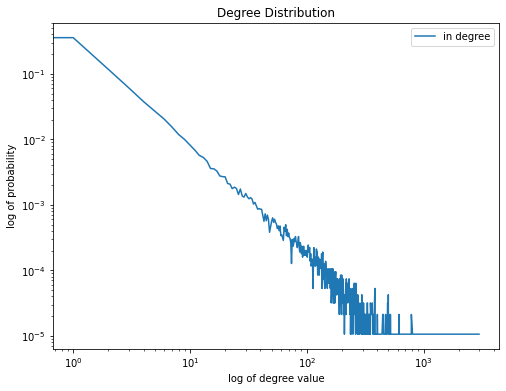

In [ ]:
plt.figure(figsize = (8,6))
# vals, counts = np.unique(list(dict(G.degree()).values()), return_counts=True)
# plt.loglog(vals, counts/sum(counts))
plt.title("Degree Distribution")
plt.xlabel('log of degree value')
plt.ylabel('log of probability')
vals, counts = np.unique(list(dict(epi_graph.in_degree()).values()), return_counts=True)
plt.loglog(vals, counts/sum(counts), label = "in degree")
plt.legend(loc = 0)
plt.savefig("degree_dist.png", dpi = 300)
plt.show()

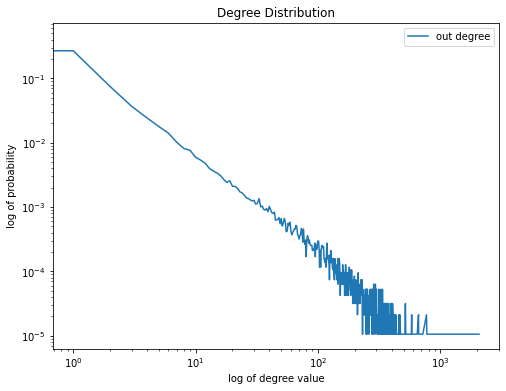

In [ ]:
plt.figure(figsize = (8,6))
# vals, counts = np.unique(list(dict(G.degree()).values()), return_counts=True)
# plt.loglog(vals, counts/sum(counts))
plt.title("Degree Distribution")
plt.xlabel('log of degree value')
plt.ylabel('log of probability')
vals, counts = np.unique(list(dict(epi_graph.out_degree()).values()), return_counts=True)
plt.loglog(vals, counts/sum(counts), label = "out degree")
plt.legend(loc = 0)
plt.savefig("degree_dist.png", dpi = 300)
plt.show()

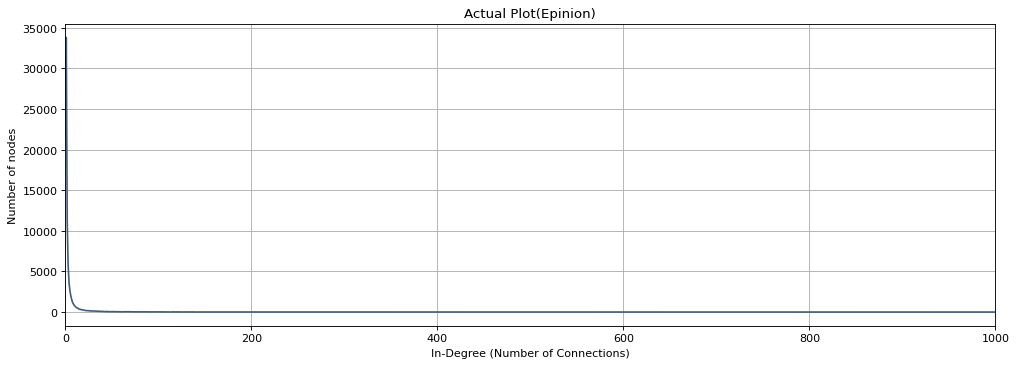

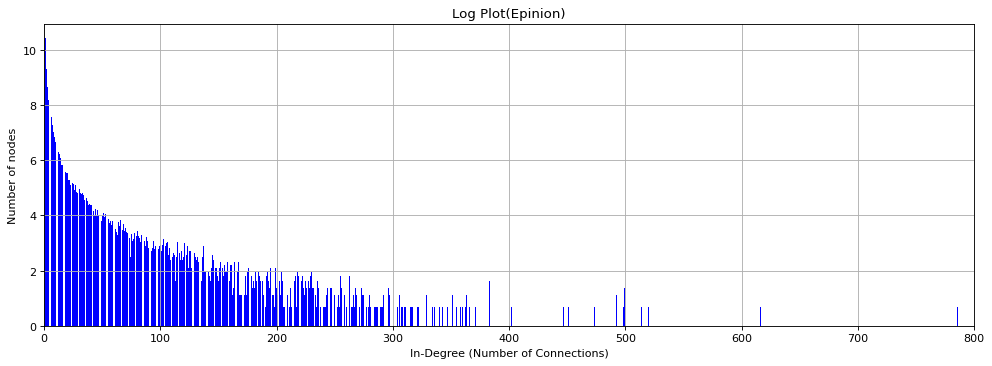

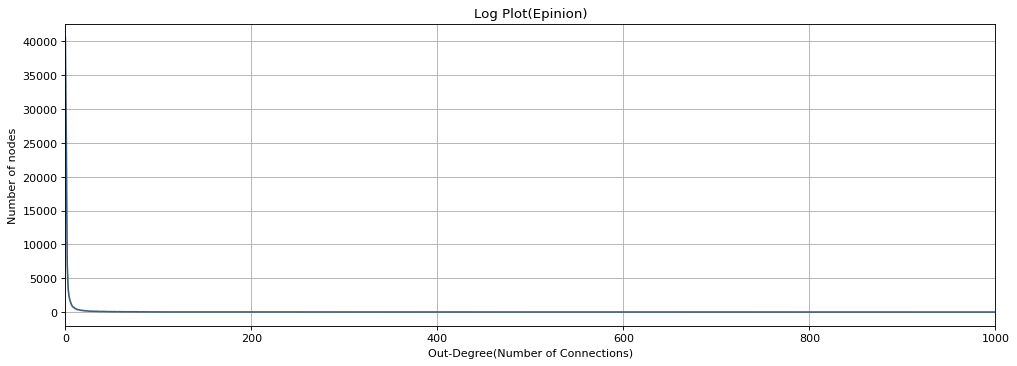

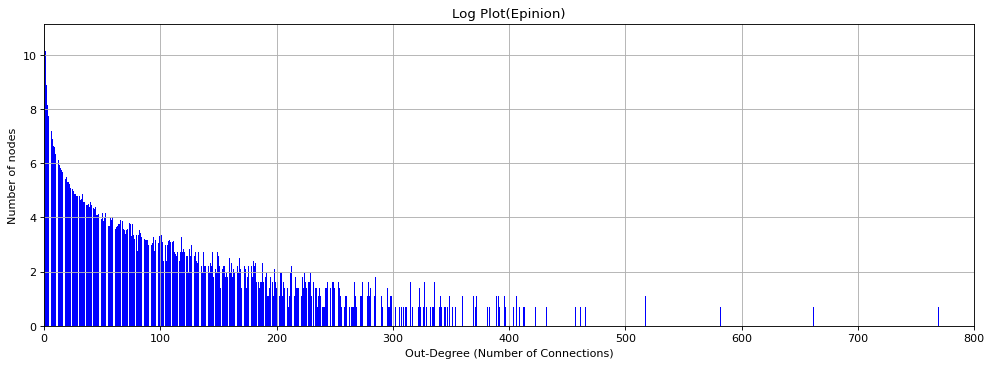

In [ ]:
degreeDistribution(epi_csv, epi_graph)

Nodes = 5881
Edges = 35592
   From  Outdegree  Pos_out  Neg_out  Indegree  Pos_in  Neg_in
0   1.0        215    324.0   -109.0       226   513.5  -287.5
1   2.0         45     94.0    -49.0        41    82.0   -41.0
2   3.0          0      0.0      0.0        21     7.5    13.5
3   4.0         63    119.0    -56.0        54   111.0   -57.0
4   5.0          3      5.0     -2.0         3     5.0    -2.0
              From    Outdegree      Pos_out      Neg_out     Indegree  \
count  5881.000000  5881.000000  5881.000000  5881.000000  5881.000000   
mean   3006.068186     6.052032     6.088420    -0.036388     6.052032   
std    1721.384064    21.088387    24.428041    19.172023    17.675082   
min       1.000000     0.000000  -301.000000  -179.000000     0.000000   
25%    1513.000000     1.000000     1.000000    -1.500000     1.000000   
50%    3002.000000     2.000000     2.000000     0.000000     2.000000   
75%    4496.000000     4.000000     5.500000     0.000000     5.000000   
max

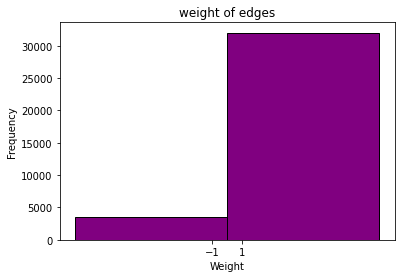

<Figure size 432x288 with 0 Axes>

In [ ]:
bitcoin_Stats = stats(bitcoin_csv,bitcoin_graph)

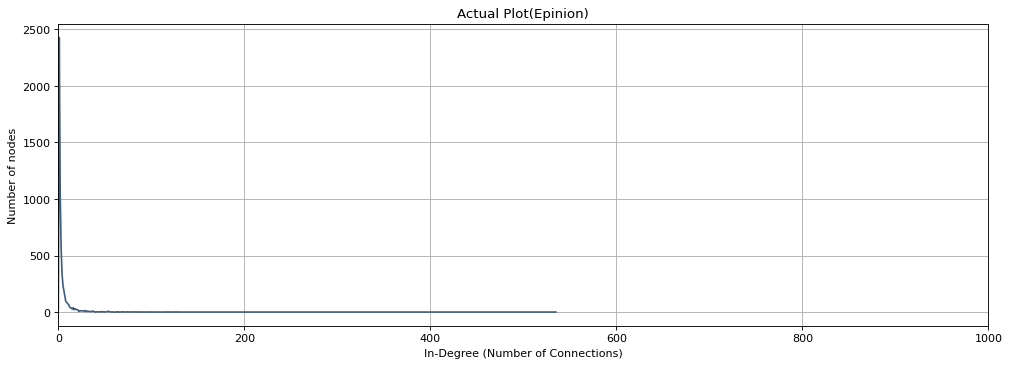

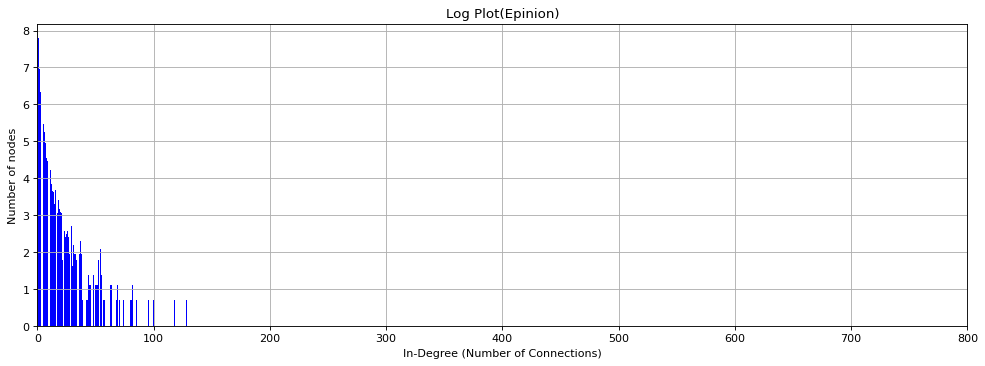

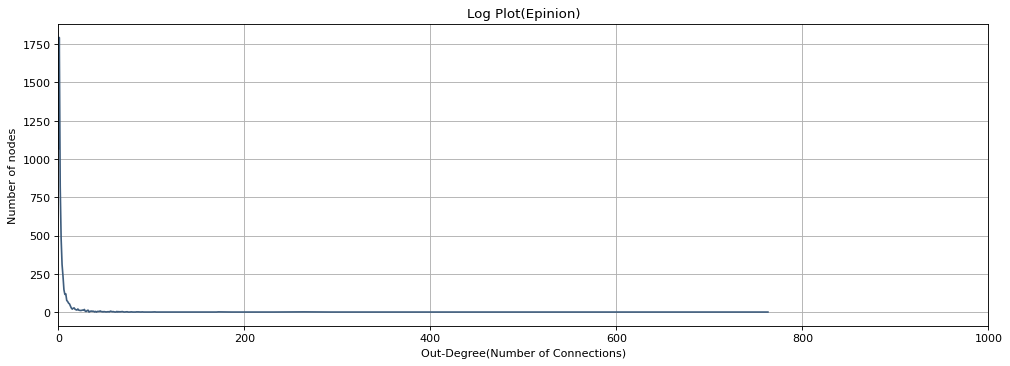

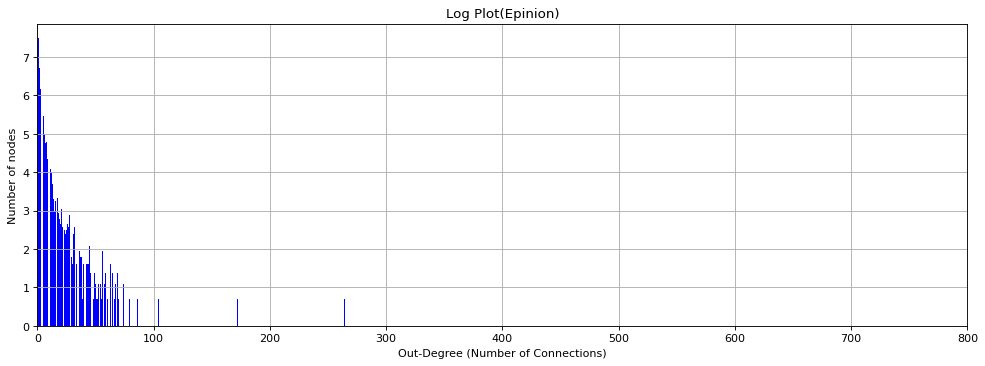

In [ ]:
degreeDistribution(bitcoin_csv, bitcoin_graph)

In [ ]:
def degreeCentrality(graph, name):
    # Degree centrality stats
    print("In-degree")
    in_degree_centrality_nodes = nx.in_degree_centrality(graph)
    in_degree_centrality_nodes = collections.Counter(in_degree_centrality_nodes)
    for k, v in in_degree_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_indegreecentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in in_degree_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count))  
    print("\n Out-degree \n")
    out_degree_centrality_nodes = nx.out_degree_centrality(graph)
    out_degree_centrality_nodes = collections.Counter(out_degree_centrality_nodes)
    for k, v in out_degree_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_outdegreecentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in out_degree_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
    # degree_centrality_nodes = nx.degree_centrality(graph)
    # degree_centrality_nodes = collections.Counter(degree_centrality_nodes)
    # for k, v in degree_centrality_nodes.most_common(100):
    #   print (k,v)
    inDegreeCentrality = pd.read_csv(name+'_indegreecentrality.csv', delimiter=',')
    outDegreeCentrality = pd.read_csv(name+'_outdegreecentrality.csv', delimiter=',')
    
    return inDegreeCentrality, outDegreeCentrality

In [ ]:
def H_value(max_value,in_values):
  sum = np.sum(max_value - np.array(in_values))
  return sum

# Sample modified degree centrality
# According to the proposed approach the node with least
# degree centrality (as H value will be high for the most
# influential node and it is in the denominator) can be
# considered as the node with most number of connections and
# hence the most influential node.

# G = nx.gn_graph(10)
# G = nx.petersen_graph()
# subax2 = plt.subplot(121)
# nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

def enhancedCentrality(graph, name):
  A = nx.adjacency_matrix(graph)
  B = A.astype(np.bool_)
  C = B.toarray()

  in_degree_centrality_nodes = nx.in_degree_centrality(graph)
  
  in_values = list(in_degree_centrality_nodes.values())
  in_values = [i*(len(in_values)-1) for i in in_values]
  max_value = max(in_values)
  sum = H_value(max_value,in_values)
  print(sum)
  clustering_array = nx.clustering(graph)
  clustering_values = list(clustering_array.values())
  clustering_values = [float(i) for i in clustering_values]
  with open(name+'_clusteringCentrality.csv', encoding='utf-8-sig', mode='w') as fp:
    fp.write('col1\n')
    for val in clustering_values:  
      fp.write('{}\n'.format(val))

  enhanced_degree_centrality = []
  if name == 'Epinion':
    for i in range(len(C)):
      #temp = (float(max_value - in_degree_centrality_nodes[i])) * float(clustering_array[i]) /float(sum) 
      temp = (float(max_value - in_degree_centrality_nodes[i])) 
      enhanced_degree_centrality.append((i,temp))
  else:
    for i,j in in_degree_centrality_nodes:
      temp = (float(max_value - j)) * float(clustering_array[i]) /float(sum) 
      enhanced_degree_centrality.append((i,temp))
    
  enhanced_degree_centrality = [ (i,'%.12f' % elem) for i,elem in enhanced_degree_centrality ]
  # print(enhanced_degree_centrality)
  file = open(name+'______enhancedInDegreeCentrality.csv', 'w+', newline ='\n') 
  with file:     
    write = csv.writer(file) 
    write.writerows(enhanced_degree_centrality) 
    
  enhancedInDegreeCentrality = pd.read_csv(name+'_enhancedInDegreeCentrality.csv', delimiter=',')
  clusteringCentrality = pd.read_csv(name+'_clusteringCentrality.csv', delimiter=',')
    
  return enhancedInDegreeCentrality, clusteringCentrality

In [ ]:
def eigenVectorCentrality(graph, name):
    # Eigen Vector centrality stats
    print("Eigen Vector centrality")
    eigenvector_centrality_nodes = nx.eigenvector_centrality_numpy(graph)
    eigenvector_centrality_nodes = collections.Counter(eigenvector_centrality_nodes)
    for k, v in eigenvector_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_eigenvectorcentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in eigenvector_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    eigenvectorCentrality = pd.read_csv(name+'_eigenvectorcentrality.csv', delimiter=',')

    return eigenvectorCentrality

In [ ]:
def khatzCentrality(graph,name):
    # Katz centrality stats
    # Not running on colab
    print("Katz centrality")
    katz_centrality_numpy_nodes = nx.katz_centrality_numpy(graph)
    katz_centrality_numpy_nodes = collections.Counter(katz_centrality_numpy_nodes)
#    for k, v in katz_centrality_numpy_nodes.most_common(10):
#      print ((k, v))
    with open(name+'_khatzcentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in katz_centrality_numpy_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    khatzCentrality = pd.read_csv(name+'_khatzcentrality.csv', delimiter=',')

    return khatzCentrality

In [ ]:
def closenessCentrality(graph, name):
    # Closeness centrality stats
    # Not running on colab
    print("closeness centrality ")
    closeness_centrality_nodes = nx.closeness_centrality(graph)
    closeness_centrality_nodes = collections.Counter(closeness_centrality_nodes)
#    for k, v in closeness_centrality_nodes.most_common(10):
#        print ((k, v))
    with open(name+'_closenesscentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in closeness_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    closenessCentrality = pd.read_csv(name+'_closenesscentrality.csv', delimiter=',')

    return closenessCentrality

In [ ]:
def betweenessCentrality(graph,name):
    # Betweenness centrality stats
    # Not running on colab
    print("Betweenness centrality ")
    betweenness_centrality_nodes = nx.betweenness_centrality(graph)
    betweenness_centrality_nodes = collections.Counter(betweenness_centrality_nodes)
#    for k, v in betweenness_centrality_nodes.most_common(10):
#        print ((k, v))
    with open(name+'_betweennessscentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in betweenness_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    betweennessCentrality = pd.read_csv(name+'_betweennessscentrality.csv', delimiter=',')

    return betweennessCentrality

In [ ]:
def degreeRelationship(Stats, graph, name):
    # Out degree and indegree relationship, relationship between positive and negative weighted outgoing 
    # edges in the network and relationship between positive and negative ingoing edges.
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(Stats['Pos_out'],Stats['Neg_out'],'o',markersize=0.4, color = 'brown')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Positive Outdegree')
    plt.ylabel('Negativetive Outdegree')
    plt.title(name+' Outdegree(Pos-Neg) relationship')
    plt.legend(['Node'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(Stats['Pos_in'],Stats['Neg_in'],'o',markersize=0.4, color = 'brown')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Positive Indegree')
    plt.ylabel('Negativetive Indegree')
    plt.title(name+' Indegree(Pos-Neg) relationship')
    plt.legend(['Node'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(Stats['Outdegree'],Stats['Indegree'],'o',markersize=0.4, color = 'brown')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Outdegree')
    plt.ylabel('Indegree')
    plt.title(name+' Outdegree-Indegree relationship')
    plt.legend(['Node'])
    plt.grid()
    plt.show()
    
    
    plt.figure(figsize=(5, 5), dpi=80)
    Deg_cor = nx.average_neighbor_degree(graph,target='out')
    dict_list = []
    for key, value in Deg_cor.items():
        temp = [key,value]
        temp[0] = graph.degree(key,'out')
        dict_list.append(temp)
    dfa11 = pd.DataFrame(dict_list,columns =['Outdegree','Average neighbors outdegree'])
    dfa21 = dfa11.groupby('Outdegree',as_index=False)['Average neighbors outdegree'].mean()
    plt.plot(dfa11['Outdegree'],dfa11['Average neighbors outdegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa21['Outdegree'],dfa21['Average neighbors outdegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Outdegree')
    plt.ylabel('Average neighbors outdegree')
    plt.title(name+' Outdegree-Neighbour outdegree relationship')
    plt.legend(['Node','Mean at same outdegree'])
    plt.grid()
    plt.show()
    
    
    plt.figure(figsize=(5, 5), dpi=80)
    Deg_cor = nx.average_neighbor_degree(graph,target='in')
    dict_list = []
    for key, value in Deg_cor.items():
        temp = [key,value]
        temp[0] = graph.degree(key,'in')
        dict_list.append(temp)
    dfa12 = pd.DataFrame(dict_list,columns =['Indegree','Average neighbors indegree'])
    # group same indegree values and take their mean
    dfa22 = dfa12.groupby('Indegree',as_index=False)['Average neighbors indegree'].mean()
    plt.plot(dfa12['Indegree'],dfa12['Average neighbors indegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa22['Indegree'],dfa22['Average neighbors indegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Indegree')
    plt.ylabel('Average neighbors indegree')
    plt.title(name+' Indegree-Neighbour indegree relationship')
    plt.legend(['Node','Mean at same indegree'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(dfa12['Indegree'],dfa11['Average neighbors outdegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa22['Indegree'],dfa21['Average neighbors outdegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Indegree')
    plt.ylabel('Average neighbors outdegree')
    plt.title(name+' Indegree-Neighbour outdegree relationship')
    plt.legend(['Node','Mean at same indegree'])
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(dfa11['Outdegree'],dfa12['Average neighbors indegree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa21['Outdegree'],dfa22['Average neighbors indegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Outdegree')
    plt.ylabel('Average neighbors indegree')
    plt.title(name+' Outdegree-Neighbour indegree relationship')
    plt.legend(['Node','Mean at same outdegree'])
    plt.grid()
    plt.show()
    
    
    
    print('In-In assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'in','in')))
    print('Out-Out assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'out','out')))
    print('In-Out assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'in','out')))
    print('Out-In assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'out','in')))
    print('Graph assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph)))
 

In [ ]:
def weakConnected(graph):
    weak = nx.weakly_connected_components(graph)
    weak_list = [c for c in sorted(weak,key=len, reverse=True)]
    weak_nodes = weak_list[0]
    weak_graph = graph.subgraph(weak_nodes)
    return weak_graph

In [ ]:
epi_weak_graph = weakConnected(epi_graph)
bit_weak_graph = weakConnected(bitcoin_graph)

In [ ]:
def powerLaw(Stats, graph):
    import math
    pos = Stats['Indegree'][Stats['Indegree'] != 0]
    pos = pos.transform(lambda x: math.floor(math.log(x)) )

    prob = pos.value_counts(normalize=True)
    threshold = 0.0001
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob.plot(kind='bar',log=True,color='r')
    plt.title('Indegree')
    plt.grid()
    
    import igraph as igraph
    pos = Stats['Indegree'][Stats['Indegree'] != 0]
    print(igraph.power_law_fit(pos))

In [ ]:
def communities(graph):
    SCC = max(nx.strongly_connected_components(graph), key=len)
    print('Size of maximal strongly connected component is ' + str(len(SCC)))
    WCC = max(nx.weakly_connected_components(graph), key=len)
    print('Size of maximal weakly connected component is ' + str(len(WCC)))
    DIF = list(set(WCC)-set(SCC))
    OUT_C = []
    IN_C = []
    IN = 0
    OUT = 0
    for index, node1 in enumerate(DIF):
        for index2, node2 in enumerate(SCC):

            if graph.has_edge(node1,node2):
                OUT+=1
                OUT_C.append(node2)
                break
            elif graph.has_edge(node2,node1):
                IN+=1
                IN_C.append(node1)
                break


    TND = len(DIF)-IN-OUT
    print(IN,OUT,TND)
    
    SCC = max(nx.strongly_connected_components(graph), key=len)
    scc_com = graph.subgraph(SCC).copy()
    scc2 = nx.Graph(scc_com)

    # Removing the weights.

    for u,v,d in scc2.edges(data=True):
        d['weight']=1

    communities =community_louvain.best_partition(scc2,random_state=5)
    
    print(set(communities.values()))
    # node numver, community it belongs to
    # find size of all communities
    # group by val -> key.sum()
    
    ind_graph = community_louvain.induced_graph(communities, scc2)

    inv_map = dict()
    for key, value in communities.items():
        inv_map.setdefault(value, list()).append(key)

    # Removing the small communities

    inv_map2 = {key:val for key, val in inv_map.items() if len(val) >= 100}
    sizes = np.array([len(inv_map2[k]) for k in list(inv_map2.keys())])

    # Removing edges from the graph:

    inv_keys = [key for key in inv_map2]
    ind_nodes = list(ind_graph.nodes())
    for node in ind_nodes:
        if node not in inv_keys:
            ind_graph.remove_node(node)
            
    print(community_louvain.modularity(communities,scc2))
    print(sizes)

In [ ]:
def richClubEffect(Stats, graph):
    
    # We want to see the rich club effect in the 100 edges with the highest indegree.
    picked = 100
    rce1 = Stats[['From','Indegree']].sort_values(by=['Indegree'], ascending=False)[0:picked]
    rich = list(rce1.From.values)
    rece_graph = graph.subgraph(rich).copy()
    # Dropping first value

    densities = np.zeros((3,picked))
    pos_edges = 0
    neg_edges = 0 
    for rank, node1 in enumerate(rich[1::]):

        for rank2, node2 in enumerate(rich[:rank+1]): 
            if graph.has_edge(node1, node2):
                if graph[node1][node2]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1
            if graph.has_edge(node2, node1):
                if graph[node2][node1]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1

        densities[0][rank] = pos_edges/(rank+2)/(rank+1)
        densities[1][rank] = neg_edges/(rank+2)/(rank+1)
        densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)

    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density(+ve effect)')
    plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density(+ve effect)')
    #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
    #plt.legend(loc="upper right")
    #plt.ylim((0,1))
    #plt.xlim((-2,picked-2))
    #plt.show()

    # Checking the one sidedness
    print(nx.reciprocity(rece_graph))
    
    
    
    # We want to see the rich club effect in the 100 edges with the highest negative_degree.
    picked = 100
    rce2 = Stats[['From','Neg_in']].sort_values(by=['Neg_in'], ascending=False)[4:picked+4]
    rich = list(rce2.From.values)
    rece_graph2 = graph.subgraph(rich).copy()
    # Dropping first value

    densities = np.zeros((3,picked))
    pos_edges = 0
    neg_edges = 0 

    for rank, node1 in enumerate(rich[1::]):

        for rank2, node2 in enumerate(rich[:rank+1]): 
            if graph.has_edge(node1, node2):
                if graph[node1][node2]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1
            if graph.has_edge(node2, node1):
                if graph[node2][node1]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1


        densities[0][rank] = pos_edges/(rank+2)/(rank+1)
        densities[1][rank] = neg_edges/(rank+2)/(rank+1)
        densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


    plt.plot( [i for i in range(0,picked)],densities[0,],'g-',label='Positive edge density(-ve effect)')
    plt.plot( [i for i in range(0,picked)],densities[1,],'m-',label='Negative edge density(-ve effect)')
    #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
    plt.legend(loc="upper right")
    plt.ylim((0,1))
    plt.xlim((-2,picked-2))
    plt.title('Rich Club Effect', fontsize = 20)
    plt.grid()
    plt.ylim([0,0.6])
    plt.xlabel('Node Number')
    plt.ylabel('Density')
    plt.show()
    
    # Checking the one sidedness
    print(nx.reciprocity(rece_graph2))

0.6515615431720759


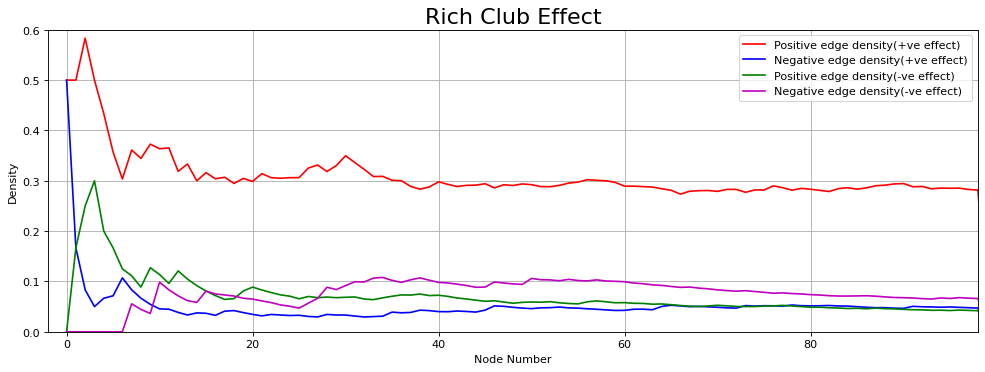

0.38847583643122674


In [ ]:
richClubEffect(epi_Stats, epi_graph)

In [ ]:
def communitiesNewCode(graph):
    # compute the best partition
    partition = community_louvain.best_partition(graph)
    print(partition)

In [ ]:
epic1, epic2  = degreeCentrality(epi_graph, 'Epinion')

In [ ]:
epic3 = eigenVectorCentrality(epi_weak_graph, 'Epinion')

Eigen Vector centrality
(11714.0, 0.0918861475783586)
(11824.0, 0.0910400874117198)
(11841.0, 0.09046681194545074)
(11693.0, 0.08907685724831653)
(11689.0, 0.0872848736769845)
(56140.0, 0.08694034215852922)
(11704.0, 0.08667695643347988)
(11853.0, 0.08665164588509319)
(11863.0, 0.08659170390321562)
(11722.0, 0.08593336697707998)


In [ ]:
#epic6 = closenessCentrality(epi_weak_graph, 'Epinion')

In [ ]:
#epic7 = betweenessCentrality(epi_weak_graph, 'Epinion')

In [ ]:
#epic4, epic5 = enhancedCentrality(epi_graph, 'Epinion')

In [ ]:
bitc1, bitc2  = degreeCentrality(bitcoin_graph, 'Bitcoin')
bitc3  = eigenVectorCentrality(bitcoin_graph, 'Bitcoin')
bitc4, bitc5  = enhancedCentrality(bitcoin_graph, 'Bitcoin')

In-degree
(35.0, 0.09098639455782312)
(2642.0, 0.07006802721088434)
(1810.0, 0.05289115646258503)
(2028.0, 0.047448979591836735)
(905.0, 0.044897959183673466)
(1.0, 0.03843537414965986)
(4172.0, 0.03775510204081632)
(7.0, 0.03673469387755102)
(4197.0, 0.03452380952380952)
(13.0, 0.03248299319727891)

 Out-degree 

(35.0, 0.12976190476190474)
(2642.0, 0.06904761904761904)
(1810.0, 0.06870748299319727)
(2125.0, 0.06751700680272109)
(2028.0, 0.049829931972789114)
(905.0, 0.044897959183673466)
(4172.0, 0.044897959183673466)
(7.0, 0.03945578231292517)
(1.0, 0.036564625850340135)
(3129.0, 0.03605442176870748)
Eigen Vector centrality
(2642.0, 0.20221058479145868)
(905.0, 0.19012652264436145)
(1810.0, 0.16982089076458207)
(35.0, 0.15472280593409393)
(2028.0, 0.1500832374217323)
(4172.0, 0.14632041848826027)
(1.0, 0.13540793758269953)
(4291.0, 0.13529331666497196)
(1334.0, 0.1313847364443384)
(4197.0, 0.12796758064486624)
3110742.9999999995


TypeError: ignored

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic1['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), align='right', color='purple')
plt.plot(n1)
val3 = bitc1['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.002, max(val3), 100),  align='right', color='purple')
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Indegree Centrality comparison')
plt.legend(['Epinion','Bitcoin'])
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic2['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False, color='b')
plt.plot(n1)
val3 = bitc2['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False, color='g')
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Outdegree Centrality')
plt.legend(['Epinion', 'Bitcoin'])
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic3['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val3 = bitc3['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Eigen Vector Centrality')
plt.legend(['Epinion', 'Bitcoin'])
plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic4['col1']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.000001, max(val1), 100), visible=False)
plt.plot(n1)

val3 = bitc4['col1']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.00001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Enhanced Indegree Centrality')
plt.legend(['Epinion','Bitcoin'])
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic5['col1']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val3 = bitc5['col1']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Clustering')
plt.legend(['Epinion', 'Bitcoin'])
plt.grid()
plt.show()


In [ ]:
powerLaw(epi_Stats, epi_graph)

In [ ]:
powerLaw(bitcoin_Stats, bitcoin_graph)

In [ ]:
communities(epi_graph)

In [ ]:
closenessCentrality(epi_graph)

In [ ]:
degreeRelationship(epi_Stats,epi_graph,'Epinion')

In [ ]:
degreeRelationship(epi_Stats,epi_graph,'Epinion')

In [ ]:
degreeRelationship(bitcoin_Stats,bitcoin_graph,'Bitcoin')

In [ ]:
print(nx.average_shortest_path_length(epi_weak_graph))

In [ ]:
print(nx.average_shortest_path_length(bit_weak_graph))

In [ ]:
ud_epi = epi_weak_graph.to_undirected()
ud_epi.remove_edges_from(nx.selfloop_edges(ud_epi))
rc = nx.rich_club_coefficient(ud_epi, normalized=True, seed=10)
n1,x1,_1 = plt.hist(rc.values(),bins=np.linspace(0, max(rc.values()), 100))
plt.plot(n1)
plt.show()

In [ ]:
nx.write_gml(bitcoin_graph, "bitcoin.gml")
allD = pd.read_csv('allData.csv', delimiter=',')
allD

In [ ]:
interS = np.intersect1d(allD['indegree'],allD['outdegree'])
interS

In [ ]:
x = [[i for i in range(4)] for j in range(4)]
sns.heatmap(x)
plt.show()

In [ ]:
import scipy.sparse
import scipy.sparse.csgraph
A = nx.adjacency_matrix(epi_weak_graph)
B = A.astype(np.bool_)
C = B.toarray().tolil()
D = scipy.sparse.csgraph.floyd_warshall( \
             C, directed=True, unweighted=True)
n = D.shape[0]
closeness_centrality = {}
for r in range(0, n):
    
    cc = 0.0
    
    possible_paths = list(enumerate(D[r, :]))
    shortest_paths = dict(filter( \
        lambda x: not x[1] == np.inf, possible_paths))
    
    total = sum(shortest_paths.values())
    n_shortest_paths = len(shortest_paths) - 1.0
    if total > 0.0 and n > 1:
        s = n_shortest_paths / (n - 1)
        cc = (n_shortest_paths / total) * s
    closeness_centrality[r] = cc